In [69]:
import torchvision
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as nnf
import numpy as np

In [108]:
# calculate normalization values
trainset = torchvision.datasets.CIFAR10(root='/usr/users/henrich1/repos/exercises_summer_school/data/convnet', train=False, transform=torchvision.transforms.ToTensor())
every_tenth_idx = list(range(0, len(trainset), 5))
trainset = torch.utils.data.Subset(trainset, every_tenth_idx)

num_samples = trainset.dataset.data.shape[0]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=num_samples, 
                                            num_workers=2)
imgs, _ = next(iter(trainloader))
dataset_mean = torch.mean(imgs, dim=(0,2,3))
dataset_std = torch.std(imgs, dim=(0,2,3))

normalized_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(dataset_mean, dataset_std)
])

# get train and validation set and dataloaders
trainset = torchvision.datasets.CIFAR10(root='/usr/users/henrich1/repos/exercises_summer_school/data/convnet', train=True, transform=normalized_transform)
every_tenth_idx = list(range(0, len(trainset), 5))
trainset = torch.utils.data.Subset(trainset, every_tenth_idx)
valset = torchvision.datasets.CIFAR10(root='/usr/users/henrich1/repos/exercises_summer_school/data/convnet', train=False, transform=normalized_transform)
every_tenth_idx = list(range(0, len(valset), 5))
valset = torch.utils.data.Subset(valset, every_tenth_idx)

trainloader = DataLoader(trainset, batch_size=1000, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=1000, shuffle=False, num_workers=2)

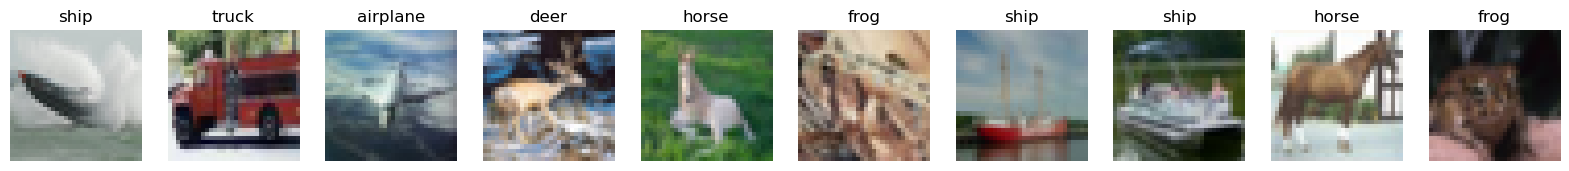

In [109]:
# visualize images from class
classes = trainset.dataset.classes
fig, axs = plt.subplots(1, 10, figsize=(20, 5))

for ax in axs:
    batch = next(iter(trainloader))
    images, labels = batch
    random_idx = torch.randint(0, len(labels), (1,))
    image = images[random_idx].squeeze()
    label = labels[random_idx]

    image = image * dataset_std[:, None, None] + dataset_mean[:, None, None]
    class_name = classes[label]
    ax.set_title(class_name)
    ax.axis('off')
    ax.imshow(image.permute(1,2,0))

In [111]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()

        modules = []
        modules.append(nn.Flatten(start_dim=1))
        for i in range(len(layer_sizes)-1):
            modules.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

            if not i == len(layer_sizes)-2:
                modules.append(nn.ReLU())

        self.layers = nn.Sequential(*modules)


    def forward(self, x):
        return self.layers(x)

In [112]:
def train(model, trainloader, valloader, optimizer, epochs, device, val_interval, savepath_best_statedict=None):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    min_val_loss = float('inf')

    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_one_epoch(model, trainloader, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        if epoch % val_interval == 0:
            val_loss, val_accuracy = validate(model, valloader, device)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

        if savepath_best_statedict is not None:
            if val_loss < min_val_loss:
                torch.save(model.state_dict(), savepath_best_statedict)
                min_val_loss = val_loss
    return train_losses, val_losses, train_accuracies, val_accuracies

def train_one_epoch(model, trainloader, optimizer, device):
    model.train()
    total_loss = 0
    total_accuracy = 0
    for x_batch, y_batch in trainloader:
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.squeeze().long().to(device)
        y_pred = model(x_batch)
        pred_class = y_pred.argmax(dim=1)
        accuracy = (pred_class == y_batch).sum() / len(y_batch)

        optimizer.zero_grad()
        loss = nnf.cross_entropy(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_accuracy += accuracy.item()
    return total_loss / len(trainloader), total_accuracy / len(trainloader)

def validate(model, valloader, device):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for x_batch, y_batch in valloader:
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.squeeze().long().to(device)
            y_pred = model(x_batch)
            pred_class = y_pred.argmax(dim=1)
            accuracy = (pred_class == y_batch).sum() / len(y_batch)
            
            loss = nnf.cross_entropy(y_pred, y_batch)
            total_loss += loss.item()
            total_accuracy += accuracy.item()
    return total_loss / len(valloader), total_accuracy / len(valloader)

In [113]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# model = MLP([3*32*32, 32, 64, 32, 10]).to(device)
model = MLP([3*32*32, 32, 32, 10]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
epochs = 10
val_interval = 1

train_losses, val_losses, train_accuracies, val_accuracies = train(model, trainloader, valloader, optimizer, epochs, device, val_interval, savepath_best_statedict=None)

cuda


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:29<00:00,  2.90s/it]


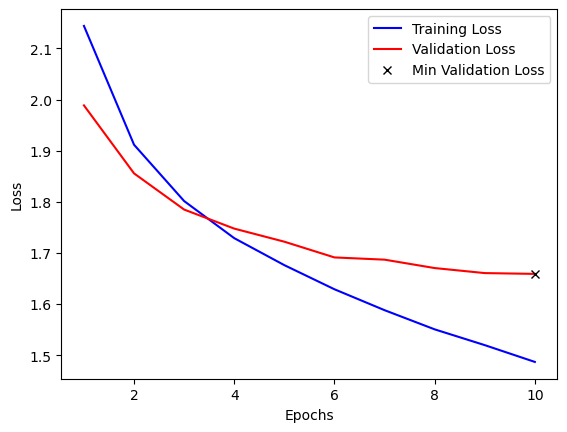

In [114]:
####################### plot losses
plt.plot(np.linspace(1, epochs, epochs), train_losses, c='blue', label='Training Loss')
plt.plot(np.linspace(1, epochs, epochs), val_losses, c='red', label='Validation Loss')

# Mark the minimum validation loss
min_val_index = np.argmin(val_losses)
plt.plot(min_val_index+1, val_losses[min_val_index], 'kx', label='Min Validation Loss')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


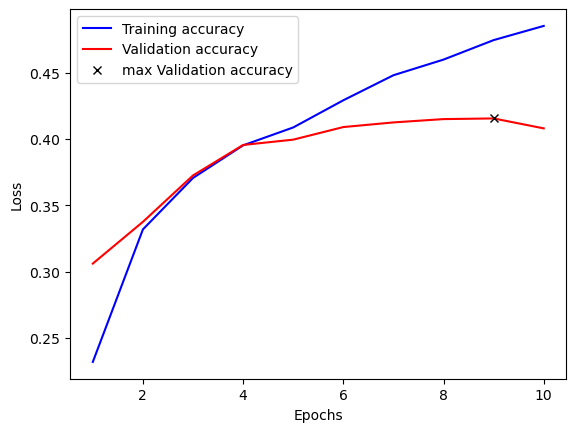

In [115]:
####################### plot losses
plt.plot(np.linspace(1, epochs, epochs), train_accuracies, c='blue', label='Training accuracy')
plt.plot(np.linspace(1, epochs, epochs), val_accuracies, c='red', label='Validation accuracy')

# Mark the minimum validation loss
min_val_index = np.argmax(val_accuracies)
plt.plot(min_val_index+1, val_accuracies[min_val_index], 'kx', label='max Validation accuracy')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()